# Аналитика: Применение ИИ в работе Mad Devs (v1 — старый опрос)

Анализ результатов первого опроса сотрудников компании об использовании ИИ в работе (март 2025).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')
PALETTE = sns.color_palette('Set2', 14)
sns.set_palette(PALETTE)

df = pd.read_csv('../Применение ИИ в работе (Responses) - старый.csv')

cols = {
    'role': df.columns[2],
    'grade': df.columns[3],
    'frequency': df.columns[4],
    'prompts_needed': df.columns[5],
    'interesting_tasks': df.columns[6],
    'tasks': df.columns[7],
    'benefits': df.columns[8],
    'not_helping': df.columns[9],
    'caution': df.columns[10],
    'tools': df.columns[11],
    'wanted_tools': df.columns[12],
    'prompt_skills': df.columns[13],
    'before_after': df.columns[14],
    'company_help': df.columns[15],
    'ai_potential': df.columns[16],
    'usecases': df.columns[17],
}

SHORT_ROLES = {
    'Разработчик Backend и интегрированных систем': 'Backend',
    'Разработчик Frontend': 'Frontend',
    'DevOps': 'DevOps',
    'Другое': 'Другое',
    'Тимлид / Техлид': 'Тимлид/Техлид',
    'Инженер ML / Data Science': 'ML/DS',
    'Менеджер по поставкам (DM)': 'DM',
    'Прочий менеджмент': 'Менеджмент',
    'Менеджер проектов (PM)': 'PM',
    'QA': 'QA',
    'Design': 'Design',
    'Recruiting': 'Recruiting',
    'Разработчик Mobile': 'Mobile',
    'HR': 'HR',
}
df['role'] = df[cols['role']].map(SHORT_ROLES).fillna(df[cols['role']])

SHORT_FREQ = {
    'Часто (каждый день)': 'Каждый день',
    'Постоянно (интегрировано в основной workflow, использую в IDE)': 'В IDE/workflow',
    'Запускаю ИИ в параллельном режиме для работы над несколькими задачами': 'Параллельный режим',
    'Иногда (3-4 раза в неделю)': 'Иногда',
    'Редко (1-2 раза в неделю)': 'Редко',
    'Никогда': 'Никогда',
}
df['freq'] = df[cols['frequency']].map(SHORT_FREQ).fillna(df[cols['frequency']])

FREQ_ORDER = ['Никогда', 'Редко', 'Иногда', 'Каждый день', 'В IDE/workflow', 'Параллельный режим']

SHORT_GRADES = {
    'Junior': 'Junior',
    'Middle': 'Middle',
    'Senior': 'Senior',
    'Intern': 'Intern',
    'Не проходил грейдинг в компании': 'Без грейда',
    'Не применимо (для сотрудников отделов)': 'Н/Д (отдел)',
}
df['grade'] = df[cols['grade']].map(SHORT_GRADES).fillna(df[cols['grade']])
GRADE_ORDER_SHORT = ['Intern', 'Junior', 'Middle', 'Senior', 'Без грейда', 'Н/Д (отдел)']

SHORT_PROMPTS = {
    '1 - получаю ответ с первого промпта': '1 промпт',
    '2-3 - после первого запроса требуется сделать еще несколько уточняющих': '2-3 промпта',
    '3-10 - веду полноценные диалоги с ИИ': '3-10 (диалог)',
    '>10 - всякий раз требуется длительный диалог с ИИ': '>10 (длинный)',
}
df['prompts_short'] = df[cols['prompts_needed']].map(SHORT_PROMPTS).fillna(df[cols['prompts_needed']])
PROMPTS_ORDER = ['1 промпт', '2-3 промпта', '3-10 (диалог)', '>10 (длинный)']


def add_pct_labels(ax, total=None, horizontal=False):
    if horizontal:
        for p in ax.patches:
            w = p.get_width()
            if w > 0:
                t = total if total else w
                ax.annotate(f'{w:.0f} ({w/t*100:.0f}%)',
                            (w, p.get_y() + p.get_height()/2),
                            ha='left', va='center', fontsize=9,
                            xytext=(5, 0), textcoords='offset points')
    else:
        for p in ax.patches:
            h = p.get_height()
            if h > 0:
                t = total if total else h
                ax.annotate(f'{h:.0f} ({h/t*100:.0f}%)',
                            (p.get_x() + p.get_width()/2, h),
                            ha='center', va='bottom', fontsize=9)


print(f'Загружено {len(df)} ответов')

Загружено 99 ответов


## 1. Демография

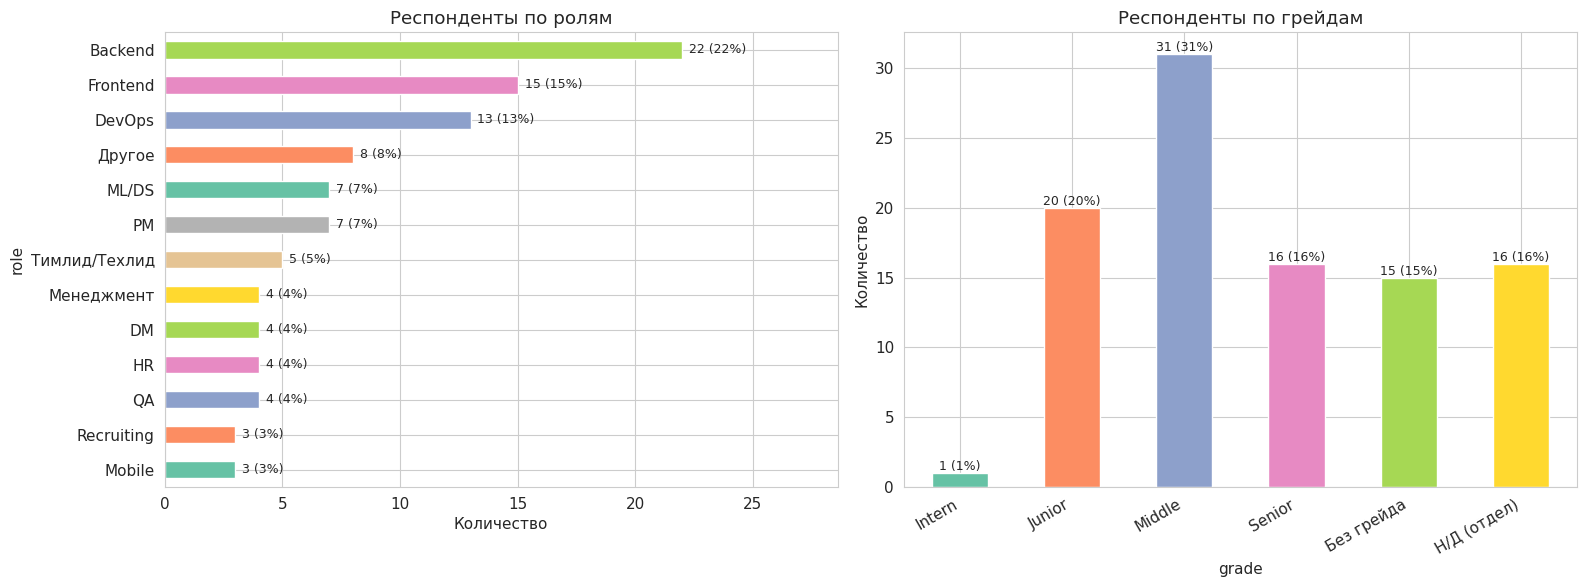

In [2]:
role_counts = df['role'].value_counts()
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
role_counts.sort_values().plot.barh(ax=ax, color=PALETTE[:len(role_counts)])
ax.set_title('Респонденты по ролям')
ax.set_xlabel('Количество')
add_pct_labels(ax, total=len(df), horizontal=True)
ax.set_xlim(0, role_counts.max() * 1.3)

ax = axes[1]
grade_counts = df['grade'].value_counts().reindex([g for g in GRADE_ORDER_SHORT if g in df['grade'].values])
grade_counts.plot.bar(ax=ax, color=PALETTE[:len(grade_counts)])
ax.set_title('Респонденты по грейдам')
ax.set_ylabel('Количество')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
add_pct_labels(ax, total=len(df))

plt.tight_layout()
plt.show()

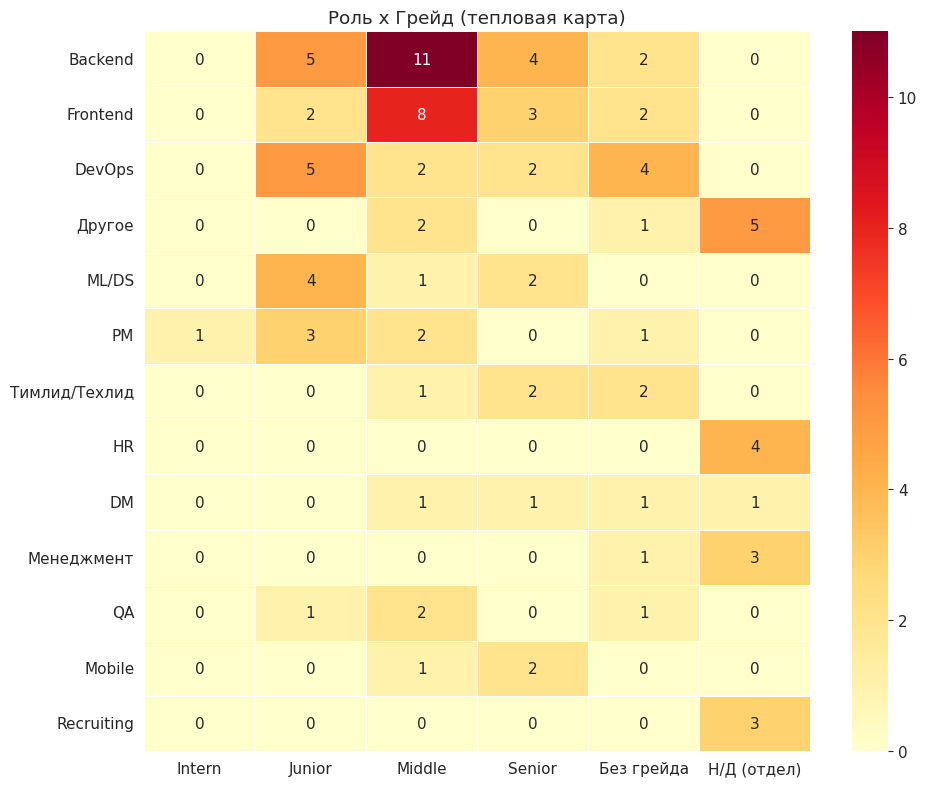

In [3]:
ct = pd.crosstab(df['role'], df['grade'])
ct = ct.reindex(columns=[g for g in GRADE_ORDER_SHORT if g in ct.columns])
ct = ct.loc[ct.sum(axis=1).sort_values(ascending=False).index]

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ct, annot=True, fmt='d', cmap='YlOrRd', ax=ax, linewidths=0.5)
ax.set_title('Роль x Грейд (тепловая карта)')
ax.set_ylabel('')
ax.set_xlabel('')
plt.tight_layout()
plt.show()

## 2. Частота использования ИИ

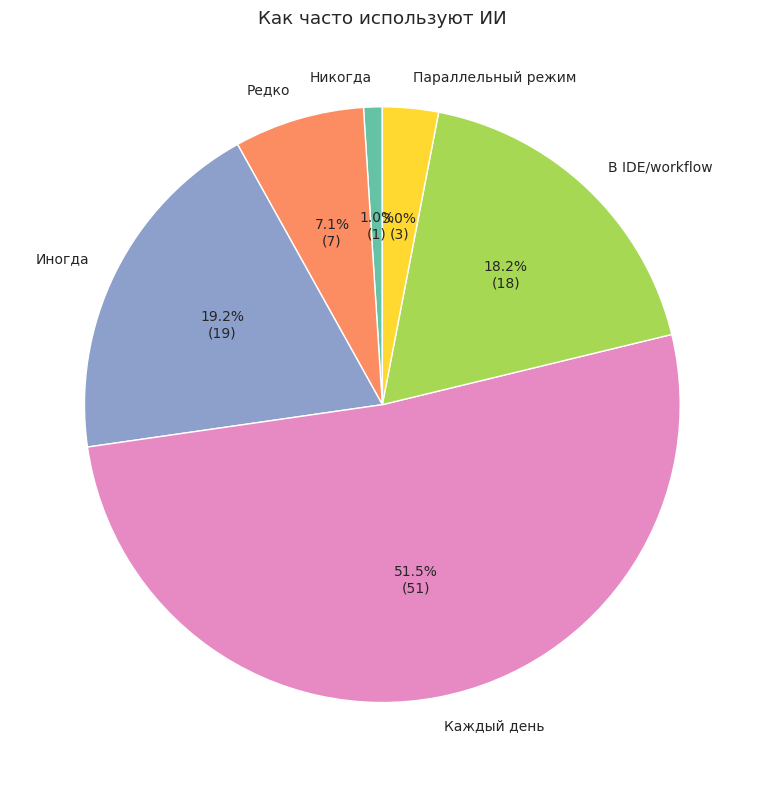

In [4]:
freq_counts = df['freq'].value_counts().reindex([f for f in FREQ_ORDER if f in df['freq'].values])

fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    freq_counts.values, labels=freq_counts.index,
    autopct=lambda p: f'{p:.1f}%\n({int(round(p*len(df)/100))})',
    startangle=90, colors=PALETTE[:len(freq_counts)],
    textprops={'fontsize': 10}
)
ax.set_title('Как часто используют ИИ')
plt.tight_layout()
plt.show()

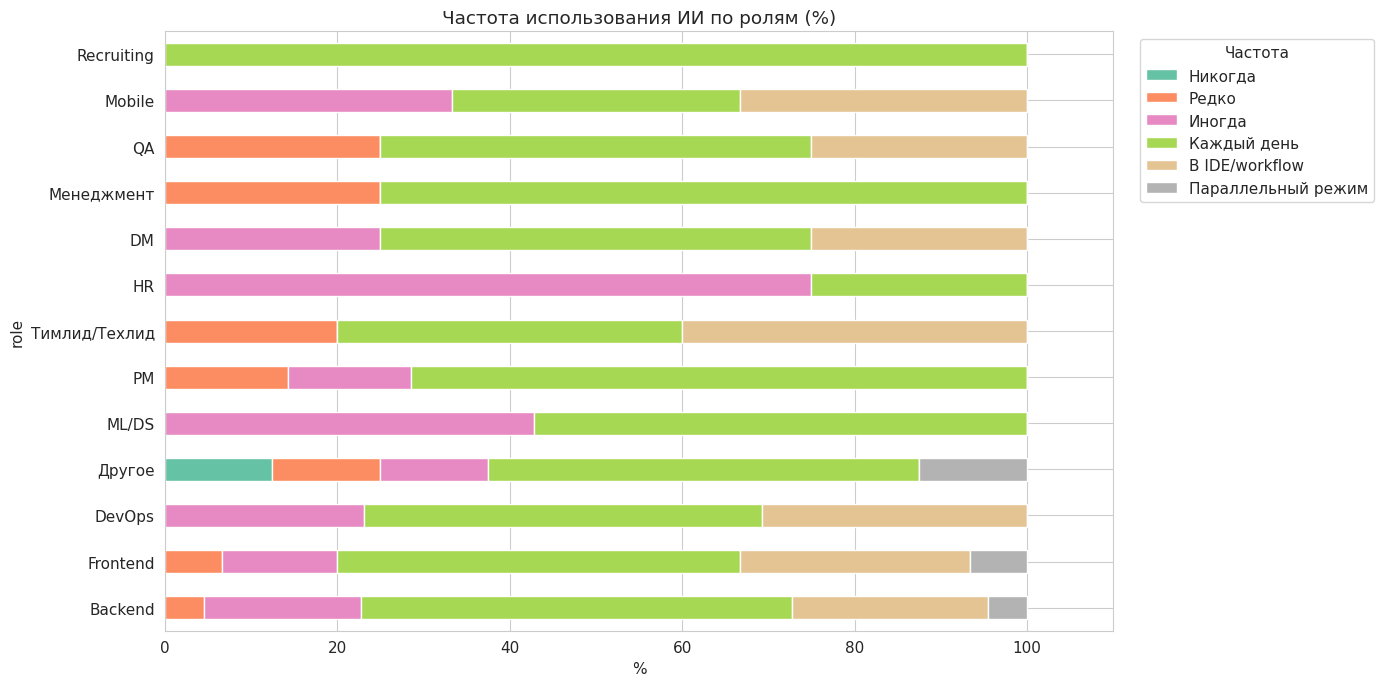

In [5]:
freq_role = pd.crosstab(df['role'], df['freq'])
freq_role = freq_role.reindex(columns=[f for f in FREQ_ORDER if f in freq_role.columns])
freq_role = freq_role.loc[freq_role.sum(axis=1).sort_values(ascending=False).index]
freq_role_pct = freq_role.div(freq_role.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(14, 7))
freq_role_pct.plot.barh(stacked=True, ax=ax, colormap='Set2')
ax.set_title('Частота использования ИИ по ролям (%)')
ax.set_xlabel('%')
ax.legend(title='Частота', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xlim(0, 110)
plt.tight_layout()
plt.show()

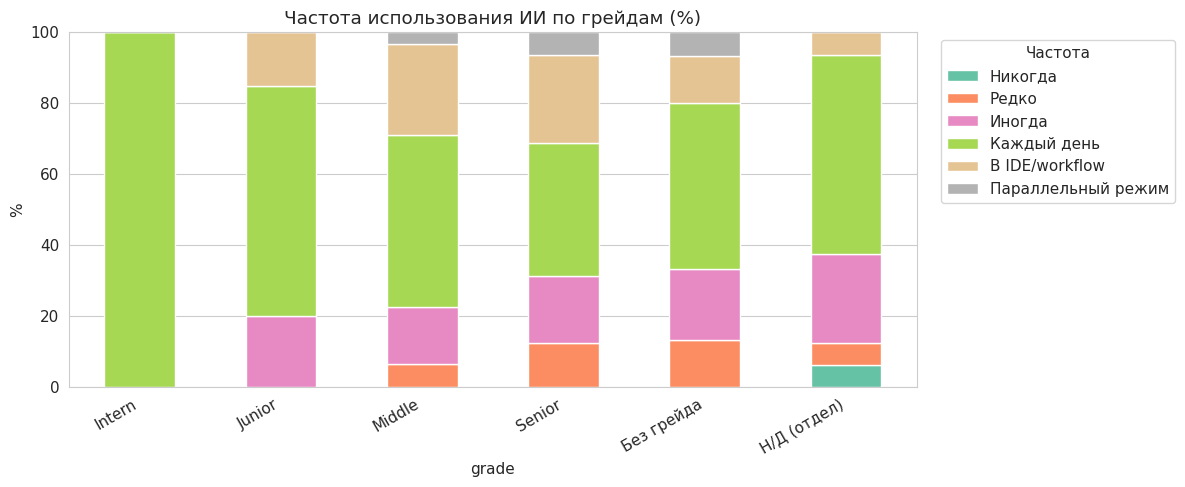

In [6]:
freq_grade = pd.crosstab(df['grade'], df['freq'])
freq_grade = freq_grade.reindex(index=[g for g in GRADE_ORDER_SHORT if g in freq_grade.index])
freq_grade = freq_grade.reindex(columns=[f for f in FREQ_ORDER if f in freq_grade.columns])
freq_grade_pct = freq_grade.div(freq_grade.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(12, 5))
freq_grade_pct.plot.bar(stacked=True, ax=ax, colormap='Set2')
ax.set_title('Частота использования ИИ по грейдам (%)')
ax.set_ylabel('%')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.legend(title='Частота', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 3. Сколько промптов нужно для ответа

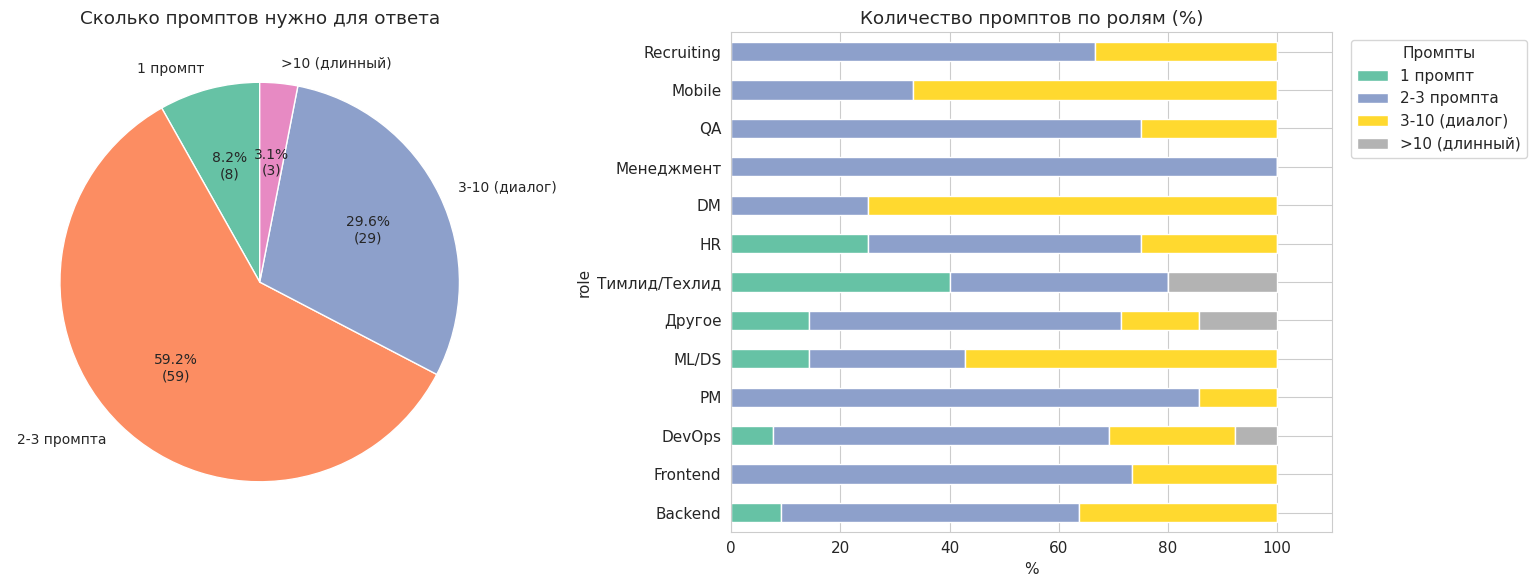

In [7]:
prompts_counts = df['prompts_short'].value_counts().reindex(
    [p for p in PROMPTS_ORDER if p in df['prompts_short'].values]
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].pie(
    prompts_counts.values, labels=prompts_counts.index,
    autopct=lambda p: f'{p:.1f}%\n({int(round(p*len(df)/100))})',
    startangle=90, colors=PALETTE[:len(prompts_counts)],
    textprops={'fontsize': 10}
)
axes[0].set_title('Сколько промптов нужно для ответа')

prompts_role = pd.crosstab(df['role'], df['prompts_short'])
prompts_role = prompts_role.reindex(columns=[p for p in PROMPTS_ORDER if p in prompts_role.columns])
prompts_role = prompts_role.loc[prompts_role.sum(axis=1).sort_values(ascending=False).index]
prompts_role_pct = prompts_role.div(prompts_role.sum(axis=1), axis=0) * 100

prompts_role_pct.plot.barh(stacked=True, ax=axes[1], colormap='Set2')
axes[1].set_title('Количество промптов по ролям (%)')
axes[1].set_xlabel('%')
axes[1].legend(title='Промпты', bbox_to_anchor=(1.02, 1), loc='upper left')
axes[1].set_xlim(0, 110)

plt.tight_layout()
plt.show()

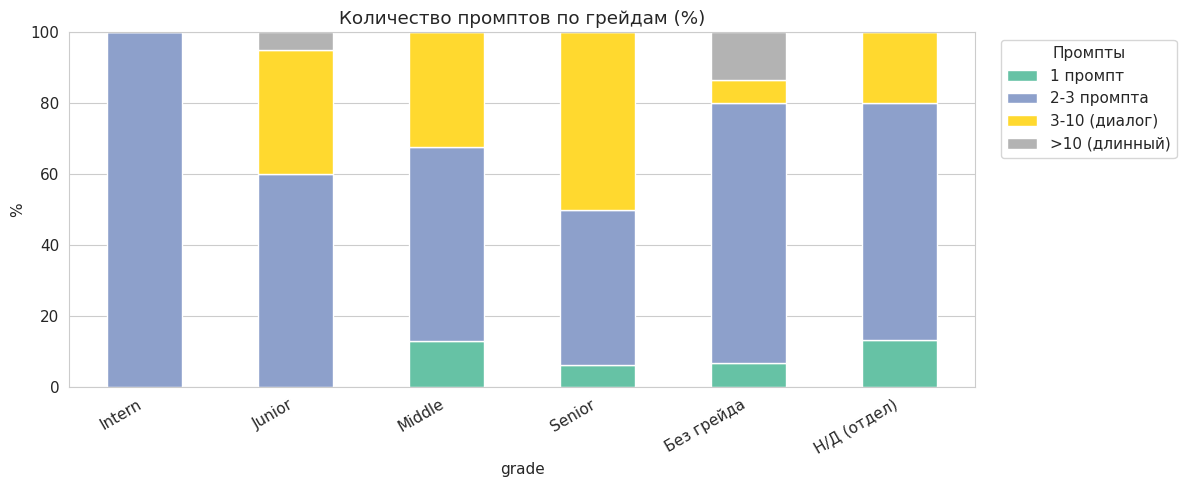

In [8]:
prompts_grade = pd.crosstab(df['grade'], df['prompts_short'])
prompts_grade = prompts_grade.reindex(index=[g for g in GRADE_ORDER_SHORT if g in prompts_grade.index])
prompts_grade = prompts_grade.reindex(columns=[p for p in PROMPTS_ORDER if p in prompts_grade.columns])
prompts_grade_pct = prompts_grade.div(prompts_grade.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(12, 5))
prompts_grade_pct.plot.bar(stacked=True, ax=ax, colormap='Set2')
ax.set_title('Количество промптов по грейдам (%)')
ax.set_ylabel('%')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.legend(title='Промпты', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 4. Для каких задач используется ИИ

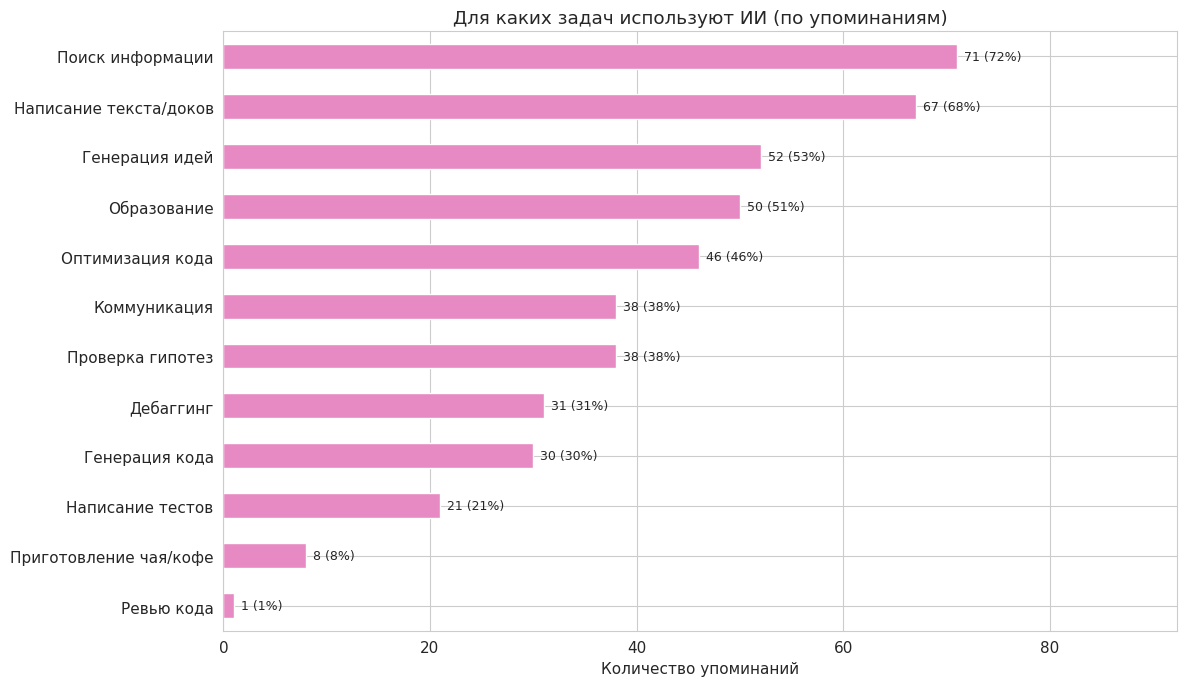

In [9]:
TASK_NORMALIZE = {
    'генерация идей': 'Генерация идей',
    'мозговой штурм': 'Генерация идей',
    'проверка гипотез': 'Проверка гипотез',
    'написание текста': 'Написание текста',
    'документация': 'Написание текста',
    'статья и т.д.': 'Написание текста',
    'оптимизация кода': 'Оптимизация кода',
    'написанного вручную': 'Оптимизация кода',
    'дебаггинг': 'Дебаггинг',
    'отладка кода': 'Дебаггинг',
    'генерация кода с нуля': 'Генерация кода',
    'поиск информации': 'Поиск информации',
    'вместо браузера': 'Поиск информации',
    'коммуникация': 'Коммуникация',
    'переписка': 'Коммуникация',
    'резюме': 'Коммуникация',
    'саммари': 'Коммуникация',
    'формулирование вопросов': 'Коммуникация',
    'образование': 'Образование',
    'интро в какую-то технологию': 'Образование',
    'написание тестов': 'Написание тестов',
    'рефакторинг': 'Рефакторинг',
    'ревью кода': 'Ревью кода',
    'перевод': 'Перевод',
}

task_items = []
task_role_rows = []
for _, row in df.iterrows():
    val = row[cols['tasks']]
    if pd.isna(val):
        continue
    seen = set()
    for raw in str(val).split(','):
        t = raw.strip().rstrip(')')
        if not t or len(t) < 3:
            continue
        key = t.lower().strip()
        combined = None
        if 'генерация идей' in key or 'мозговой штурм' in key:
            combined = 'Генерация идей'
        elif 'проверка гипотез' in key:
            combined = 'Проверка гипотез'
        elif 'написание текста' in key or 'документация' in key or 'статья' in key:
            combined = 'Написание текста/доков'
        elif 'оптимизация кода' in key or 'написанного вручную' in key:
            combined = 'Оптимизация кода'
        elif 'дебаггинг' in key or 'отладка' in key:
            combined = 'Дебаггинг'
        elif 'генерация кода' in key:
            combined = 'Генерация кода'
        elif 'поиск информации' in key or 'вместо браузера' in key:
            combined = 'Поиск информации'
        elif 'коммуникация' in key or 'переписка' in key or 'саммари' in key or 'формулирование' in key or 'резюме' in key:
            combined = 'Коммуникация'
        elif 'образование' in key or 'интро в' in key or 'технологию' in key:
            combined = 'Образование'
        elif 'тест' in key:
            combined = 'Написание тестов'
        elif 'рефакторинг' in key:
            combined = 'Рефакторинг'
        elif 'ревью' in key:
            combined = 'Ревью кода'
        elif 'перевод' in key:
            combined = 'Перевод'
        elif 'приготовление' in key or 'кофе' in key or 'чая' in key or 'рецепт' in key:
            combined = 'Приготовление чая/кофе'
        else:
            continue
        if combined and combined not in seen:
            seen.add(combined)
            task_items.append(combined)
            task_role_rows.append({'task': combined, 'role': row['role']})

task_counts = pd.Series(Counter(task_items)).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(12, 7))
task_counts.plot.barh(ax=ax, color=PALETTE[3])
ax.set_title('Для каких задач используют ИИ (по упоминаниям)')
ax.set_xlabel('Количество упоминаний')
add_pct_labels(ax, total=len(df), horizontal=True)
ax.set_xlim(0, task_counts.max() * 1.3)
plt.tight_layout()
plt.show()

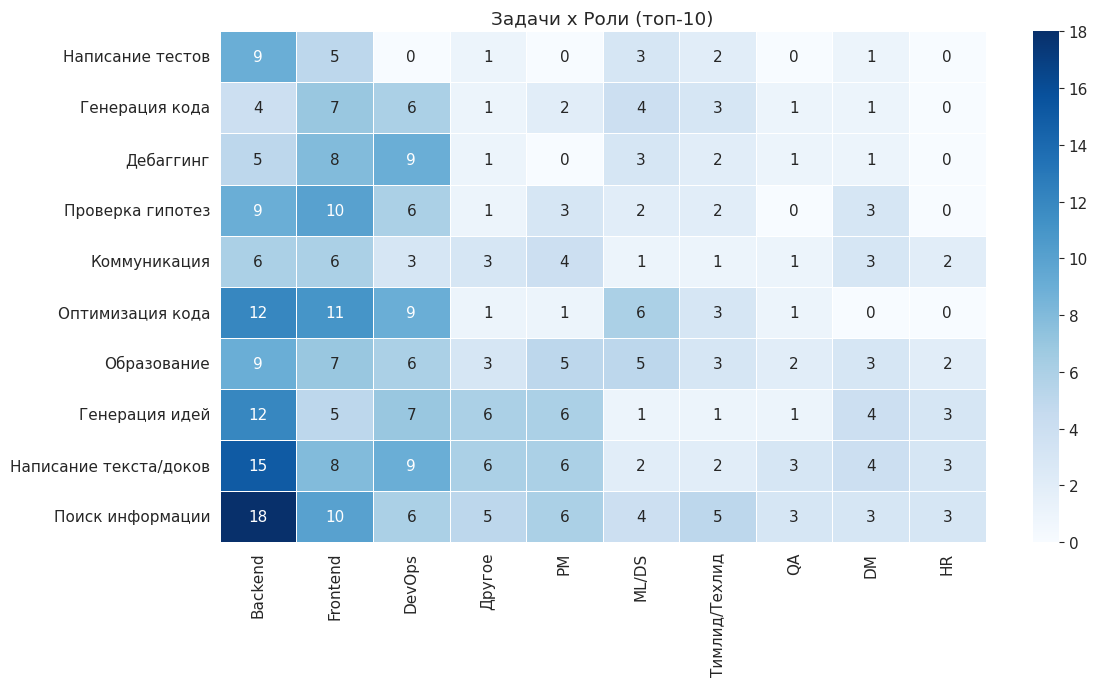

In [10]:
task_role_df = pd.DataFrame(task_role_rows)
task_role_ct = pd.crosstab(task_role_df['task'], task_role_df['role'])
top_roles = df['role'].value_counts().head(10).index
task_role_ct = task_role_ct[[r for r in top_roles if r in task_role_ct.columns]]
task_role_ct = task_role_ct.loc[task_counts.index[-10:]]

fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(task_role_ct, annot=True, fmt='d', cmap='Blues', ax=ax, linewidths=0.5)
ax.set_title('Задачи x Роли (топ-10)')
ax.set_ylabel('')
ax.set_xlabel('')
plt.tight_layout()
plt.show()

## 5. Польза от ИИ

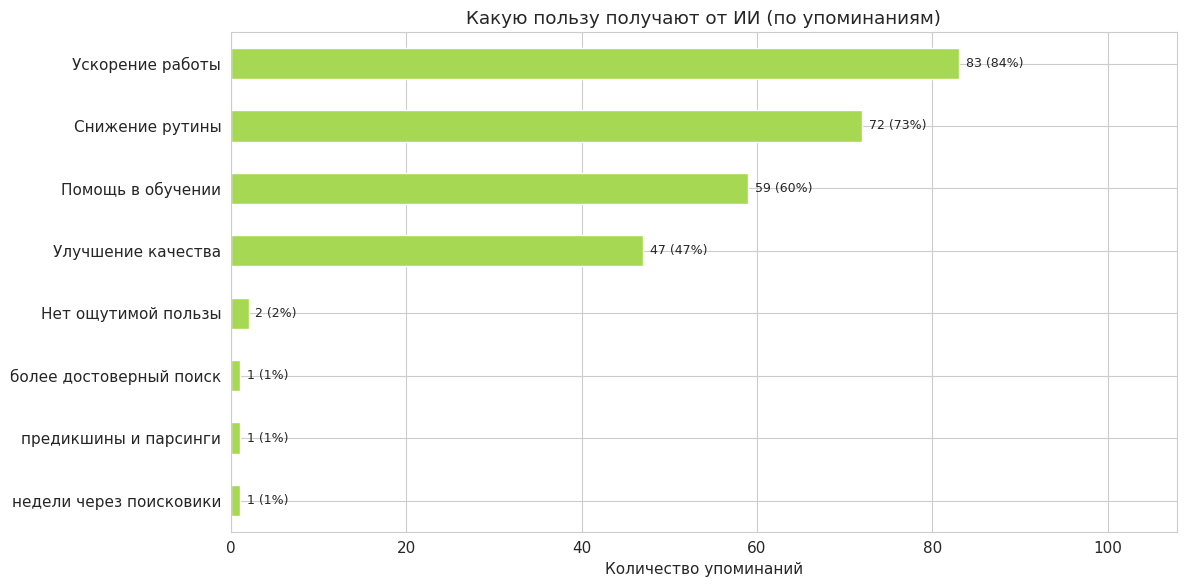

In [11]:
benefit_items = []
benefit_role_rows = []
for _, row in df.iterrows():
    val = row[cols['benefits']]
    if pd.isna(val):
        continue
    seen = set()
    for raw in str(val).split(','):
        b = raw.strip()
        if not b or len(b) < 3:
            continue
        normalized = b
        if 'ускорение' in b.lower():
            normalized = 'Ускорение работы'
        elif 'рутин' in b.lower():
            normalized = 'Снижение рутины'
        elif 'обучен' in b.lower() or 'изучен' in b.lower():
            normalized = 'Помощь в обучении'
        elif 'структур' in b.lower():
            normalized = 'Структурирование мыслей'
        elif 'качеств' in b.lower():
            normalized = 'Улучшение качества'
        elif 'обратн' in b.lower():
            normalized = 'Обратная связь'
        elif 'работает за' in b.lower():
            normalized = 'ИИ работает за меня'
        if normalized not in seen:
            seen.add(normalized)
            benefit_items.append(normalized)
            benefit_role_rows.append({'benefit': normalized, 'role': row['role']})

benefit_counts = pd.Series(Counter(benefit_items)).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(12, 6))
benefit_counts.plot.barh(ax=ax, color=PALETTE[4])
ax.set_title('Какую пользу получают от ИИ (по упоминаниям)')
ax.set_xlabel('Количество упоминаний')
add_pct_labels(ax, total=len(df), horizontal=True)
ax.set_xlim(0, benefit_counts.max() * 1.3)
plt.tight_layout()
plt.show()

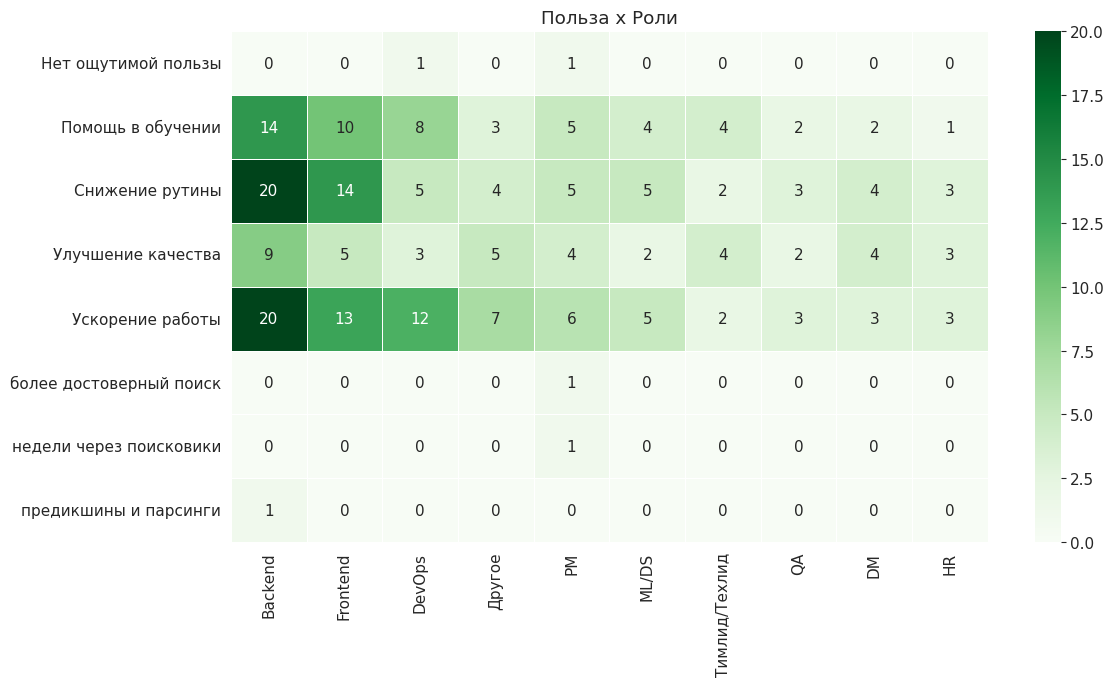

In [12]:
benefit_role_df = pd.DataFrame(benefit_role_rows)
benefit_role_ct = pd.crosstab(benefit_role_df['benefit'], benefit_role_df['role'])
benefit_role_ct = benefit_role_ct[[r for r in top_roles if r in benefit_role_ct.columns]]

fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(benefit_role_ct, annot=True, fmt='d', cmap='Greens', ax=ax, linewidths=0.5)
ax.set_title('Польза x Роли')
ax.set_ylabel('')
ax.set_xlabel('')
plt.tight_layout()
plt.show()

## 6. Где ИИ НЕ помогает и когда нужна осторожность

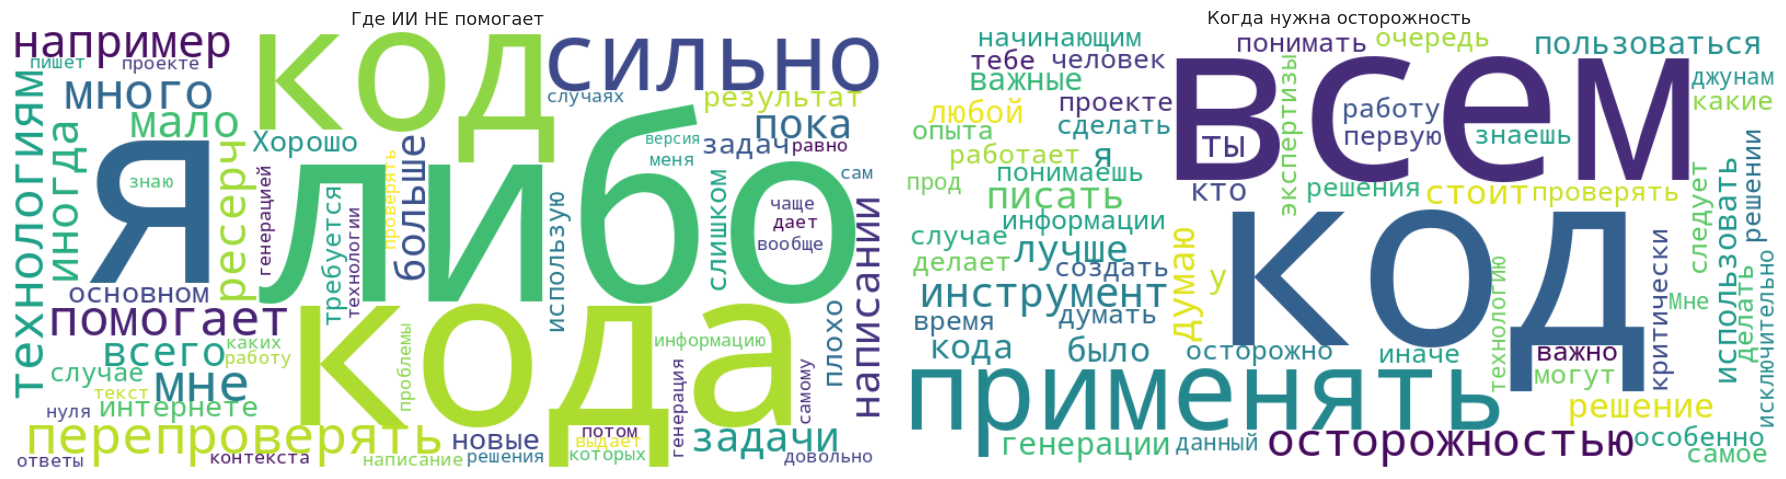

Ответов "где не помогает": 60
Ответов "осторожность": 63

Примеры — где НЕ помогает:
  1. я использую бесплатную версию, иногда требуется платная версия, чтобы база была более свежая. Также ИИ не всегда понимает конкретную цель, что ты от н
  2. Задачи, связанные с очень сложными и мало освещенными темами. В моем случае это mad location manager, пробовал совершенно нестандартное использование 
  3. в подготовке Google Slides или Power Point. Это жесть пока. 
  4. в поисках решении - может сгенерировать решение которое не возможно реализовать с помощю выбранных инструментов.
  5. Бывают случаи, когда ИИ может выдать недостоверную информацию(галюцинации). Пока не было случаев, чтобы это сильно помешало, но в любом случае нужно п

Примеры — осторожность:
  1. джунам.ИИ нужно использовать исключительно как инструмент и не использовать его на технологию, которая будет за вас думать и писать код.
  2. Мне :)
  3. ,На данный момент думаю, что надо всем и всегда применять с осторожностью, отпр

In [13]:
from wordcloud import WordCloud

STOP_WORDS_RU = {
    'и', 'в', 'на', 'с', 'по', 'для', 'не', 'что', 'это', 'как', 'но',
    'он', 'она', 'они', 'его', 'её', 'их', 'то', 'от', 'из', 'к', 'за',
    'при', 'до', 'или', 'а', 'же', 'бы', 'ли', 'так', 'уже', 'ещё',
    'еще', 'да', 'нет', 'без', 'об', 'ко', 'чтобы', 'когда', 'если',
    'тоже', 'более', 'менее', 'очень', 'может', 'нужно', 'свой', 'мой',
    'который', 'которая', 'которые', 'которого', 'быть', 'был', 'была',
    'были', 'есть', 'будет', 'через', 'после', 'перед', 'себя', 'себе',
    'чем', 'где', 'всё', 'все', 'вот', 'над', 'под', 'между', 'этот',
    'эта', 'эти', 'того', 'этого', 'тем', 'там', 'тут', 'потому',
    'поэтому', 'также', 'только', 'просто', 'даже', 'можно', 'нужно',
    'надо', 'всегда', 'никогда', 'ии', 'при', 'про',
}

not_helping = df[cols['not_helping']].dropna().astype(str)
not_helping = not_helping[~not_helping.str.strip().isin(['-', 'нет', 'Нет', '', 'не знаю', '-\n'])]
not_helping_text = ' '.join(not_helping.values)

caution = df[cols['caution']].dropna().astype(str)
caution = caution[~caution.str.strip().isin(['-', 'нет', 'Нет', '', '-\n'])]
caution_text = ' '.join(caution.values)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

if len(not_helping_text.strip()) > 20:
    wc1 = WordCloud(width=800, height=400, background_color='white',
                    stopwords=STOP_WORDS_RU, max_words=60, collocations=False).generate(not_helping_text)
    axes[0].imshow(wc1, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Где ИИ НЕ помогает', fontsize=13)

if len(caution_text.strip()) > 20:
    wc2 = WordCloud(width=800, height=400, background_color='white',
                    stopwords=STOP_WORDS_RU, max_words=60, collocations=False).generate(caution_text)
    axes[1].imshow(wc2, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Когда нужна осторожность', fontsize=13)

plt.tight_layout()
plt.show()

print(f'Ответов "где не помогает": {len(not_helping)}')
print(f'Ответов "осторожность": {len(caution)}')
print('\nПримеры — где НЕ помогает:')
for i, t in enumerate(not_helping.head(5).values, 1):
    print(f'  {i}. {t[:150]}')
print('\nПримеры — осторожность:')
for i, t in enumerate(caution.head(5).values, 1):
    print(f'  {i}. {t[:150]}')

## 7. Ландшафт ИИ-инструментов

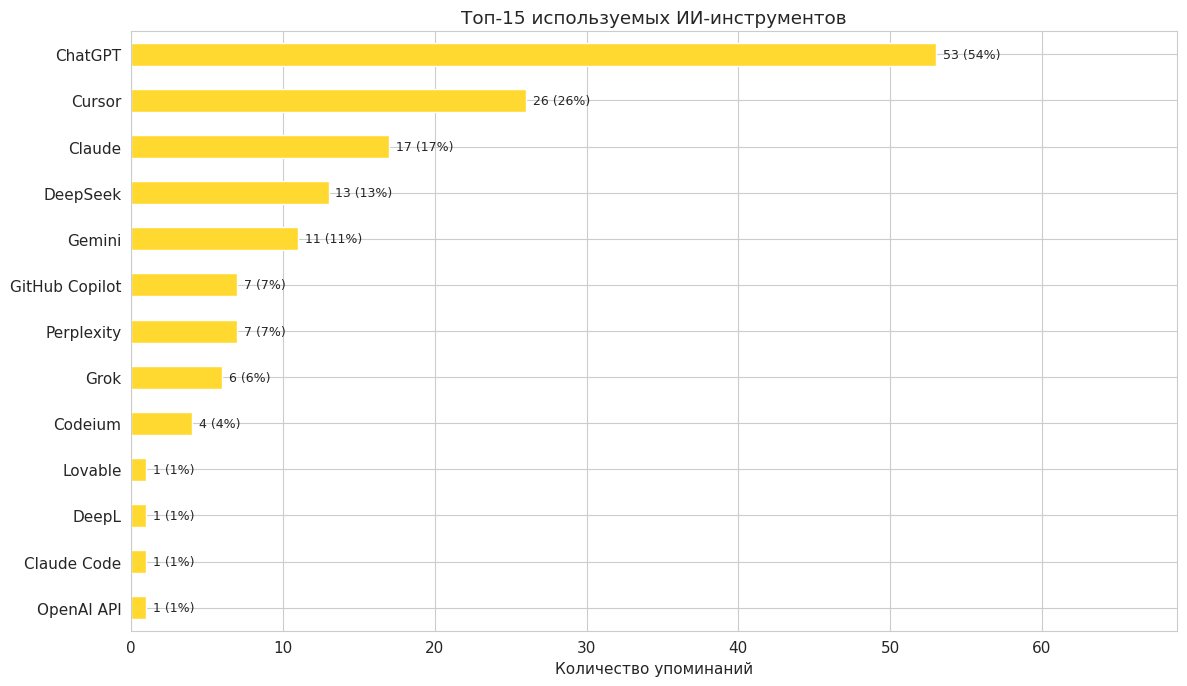

In [14]:
TOOL_NORMALIZE = {
    'claude': 'Claude',
    'клод': 'Claude',
    'claude ai': 'Claude',
    'anthropic claude': 'Claude',
    'claude code': 'Claude Code',
    'клод код': 'Claude Code',
    'claude-code': 'Claude Code',
    'claudecode': 'Claude Code',
    'claude with mcps': 'Claude Code',
    'cursor': 'Cursor',
    'курсор': 'Cursor',
    'chatgpt': 'ChatGPT',
    'chat gpt': 'ChatGPT',
    'чатгпт': 'ChatGPT',
    'chat-gpt': 'ChatGPT',
    'gpt': 'ChatGPT',
    'gpt4': 'ChatGPT',
    'gpt-4': 'ChatGPT',
    'gpt-4o': 'ChatGPT',
    'openai': 'ChatGPT',
    'openai api': 'OpenAI API',
    'copilot': 'GitHub Copilot',
    'github copilot': 'GitHub Copilot',
    'gemini': 'Gemini',
    'гемини': 'Gemini',
    'google gemini': 'Gemini',
    'deepseek': 'DeepSeek',
    'deep seek': 'DeepSeek',
    'perplexity': 'Perplexity',
    'перплексити': 'Perplexity',
    'windsurf': 'Windsurf',
    'codeium': 'Codeium',
    'codium': 'Codeium',
    'midjourney': 'Midjourney',
    'миджорни': 'Midjourney',
    'v0': 'v0',
    'grok': 'Grok',
    'грок': 'Grok',
    'bolt': 'Bolt',
    'bolt.new': 'Bolt',
    'lovable': 'Lovable',
    'deepl': 'DeepL',
    'notion ai': 'Notion AI',
    'notion': 'Notion AI',
    'cline': 'Cline',
    'aider': 'Aider',
    'suno': 'Suno',
    'dall-e': 'DALL-E',
    'dalle': 'DALL-E',
    'stable diffusion': 'Stable Diffusion',
    'supermaven': 'Supermaven',
    'tabnine': 'Tabnine',
    'phind': 'Phind',
}

URL_TO_TOOL = {
    'chat.openai.com': 'ChatGPT',
    'chatgpt.com': 'ChatGPT',
    'openai.com': 'ChatGPT',
    'claude.ai': 'Claude',
    'anthropic.com': 'Claude',
    'gemini.google.com': 'Gemini',
    'copilot.github.com': 'GitHub Copilot',
    'github.com/features/copilot': 'GitHub Copilot',
    'cursor.com': 'Cursor',
    'cursor.sh': 'Cursor',
    'perplexity.ai': 'Perplexity',
    'deepseek.com': 'DeepSeek',
    'deepl.com': 'DeepL',
    'midjourney.com': 'Midjourney',
    'grok.x.ai': 'Grok',
    'bolt.new': 'Bolt',
    'v0.dev': 'v0',
    'phind.com': 'Phind',
    'codeium.com': 'Codeium',
    'tabnine.com': 'Tabnine',
    'notion.so': 'Notion AI',
}


def extract_tools(text):
    results = set()
    urls = re.findall(r'https?://(?:www\.)?([\w.-]+(?:/[\w.-]*)?)', text)
    for url in urls:
        for pattern, tool_name in URL_TO_TOOL.items():
            if pattern in url:
                results.add(tool_name)
                break
    parts = re.split(r'[,;\n]+', text)
    for p in parts:
        t = re.sub(r'https?://\S+', '', p).strip().strip('.')
        if not t or len(t) < 2:
            continue
        key = t.lower().strip()
        if key in TOOL_NORMALIZE:
            results.add(TOOL_NORMALIZE[key])
        else:
            for norm_key, norm_val in TOOL_NORMALIZE.items():
                if norm_key in key:
                    results.add(norm_val)
                    break
    return results


tool_items = []
tool_role_rows = []
for _, row in df.iterrows():
    val = row[cols['tools']]
    if pd.isna(val):
        continue
    tools = extract_tools(str(val))
    for t in tools:
        tool_items.append(t)
        tool_role_rows.append({'tool': t, 'role': row['role']})

tool_counts = pd.Series(Counter(tool_items)).sort_values(ascending=True)
top_tools = tool_counts.tail(15)

fig, ax = plt.subplots(figsize=(12, 7))
top_tools.plot.barh(ax=ax, color=PALETTE[5])
ax.set_title('Топ-15 используемых ИИ-инструментов')
ax.set_xlabel('Количество упоминаний')
add_pct_labels(ax, total=len(df), horizontal=True)
ax.set_xlim(0, top_tools.max() * 1.3)
plt.tight_layout()
plt.show()

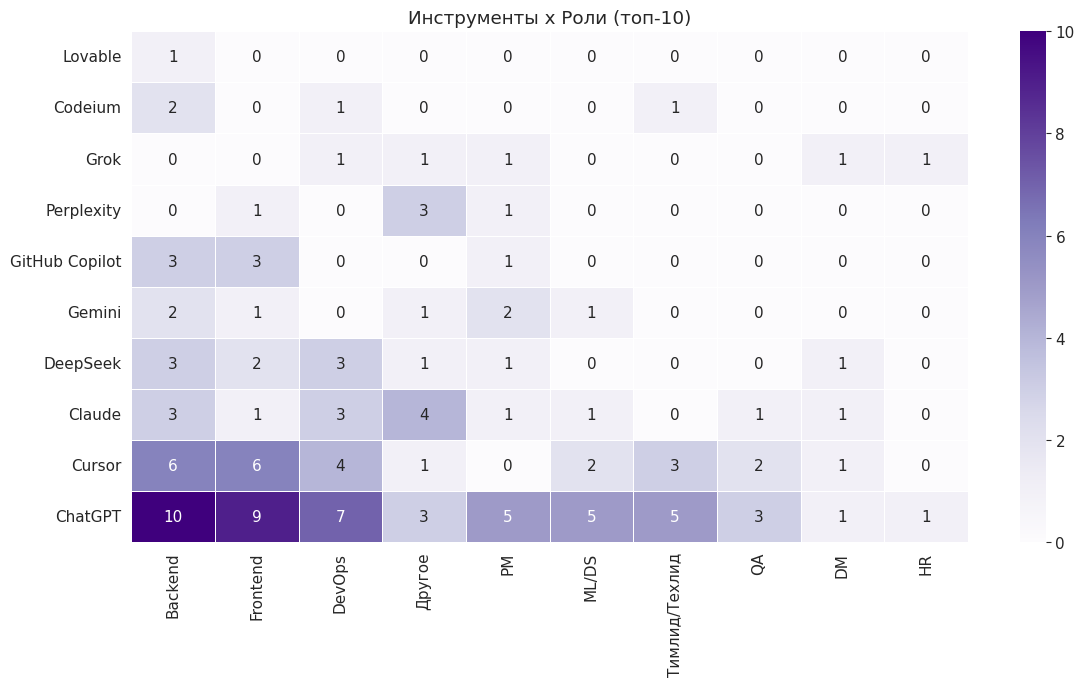

In [15]:
tool_role_df = pd.DataFrame(tool_role_rows)
top_tool_names = tool_counts.tail(10).index.tolist()
tool_role_ct = pd.crosstab(tool_role_df['tool'], tool_role_df['role'])
tool_role_ct = tool_role_ct.loc[[t for t in top_tool_names if t in tool_role_ct.index]]
tool_role_ct = tool_role_ct[[r for r in top_roles if r in tool_role_ct.columns]]

fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(tool_role_ct, annot=True, fmt='d', cmap='Purples', ax=ax, linewidths=0.5)
ax.set_title('Инструменты x Роли (топ-10)')
ax.set_ylabel('')
ax.set_xlabel('')
plt.tight_layout()
plt.show()

## 8. Желаемые инструменты

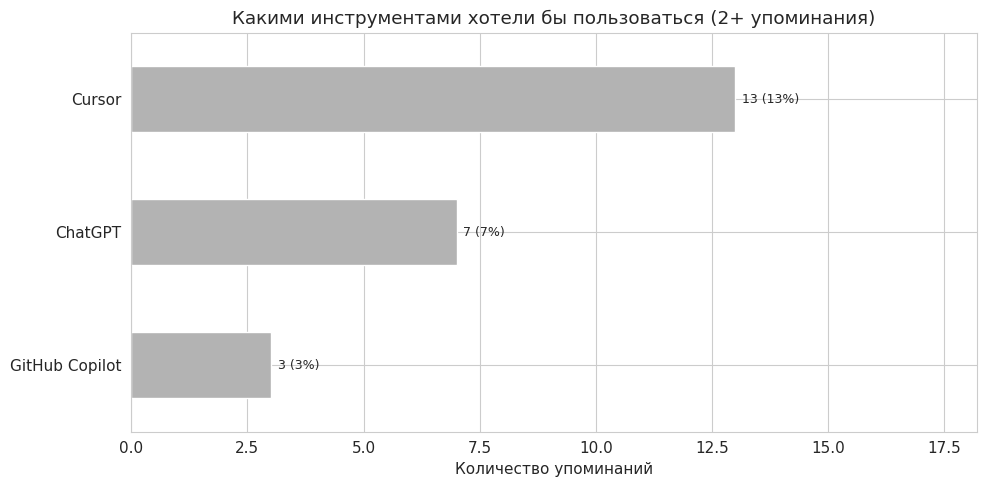


Примеры ответов:
  1. Cursor - останавливает то, что нет бесплатной версии, точнее она закончена. Хотел бы платную версию
  2. Хочу попробовать курсор, времени на изучение мало.
  3. инструментами по генерации фото или видео. Пока не добрался туда. Что останавливает... как-то в прошлом пробовал и адекватно не получилось. может это.
  4. Да нет никаких причин) Пользуюсь тем, что считаю полезным
  5. Не могу ответить, так как не изучал подробно тему AI инструментов
  6. Чем хочу пользуюсь, ничего не останавливает. Единственное - есть иногда ощущение, что выпадаю из контекста новых инструментов и могу упускать что-то н
  7. Платный gpt - в падлу платить, т.к. иногда хватает и бесплатного или пользуюсь аналогами. А платный gpt хочу, чтобы узнать его возможности. Да, да, мн
  8. Я пока мало пользовался инструментами для генерации картинок и видео. Всё не добираюсь начать ими пользоваться, чтобы экономить еще и время на ассетах


In [16]:
wanted_items = []
for val in df[cols['wanted_tools']].dropna():
    tools = extract_tools(str(val))
    wanted_items.extend(tools)

wanted_counts = pd.Series(Counter(wanted_items)).sort_values(ascending=True)
wanted_counts = wanted_counts[wanted_counts >= 2]

if len(wanted_counts) > 0:
    fig, ax = plt.subplots(figsize=(10, 5))
    wanted_counts.plot.barh(ax=ax, color=PALETTE[7])
    ax.set_title('Какими инструментами хотели бы пользоваться (2+ упоминания)')
    ax.set_xlabel('Количество упоминаний')
    add_pct_labels(ax, total=len(df), horizontal=True)
    ax.set_xlim(0, wanted_counts.max() * 1.4)
    plt.tight_layout()
    plt.show()
else:
    print('Недостаточно структурированных данных для графика')

print('\nПримеры ответов:')
for i, t in enumerate(df[cols['wanted_tools']].dropna().head(8).values, 1):
    print(f'  {i}. {str(t)[:150]}')

## 9. Развитие навыков промпт-инжиниринга

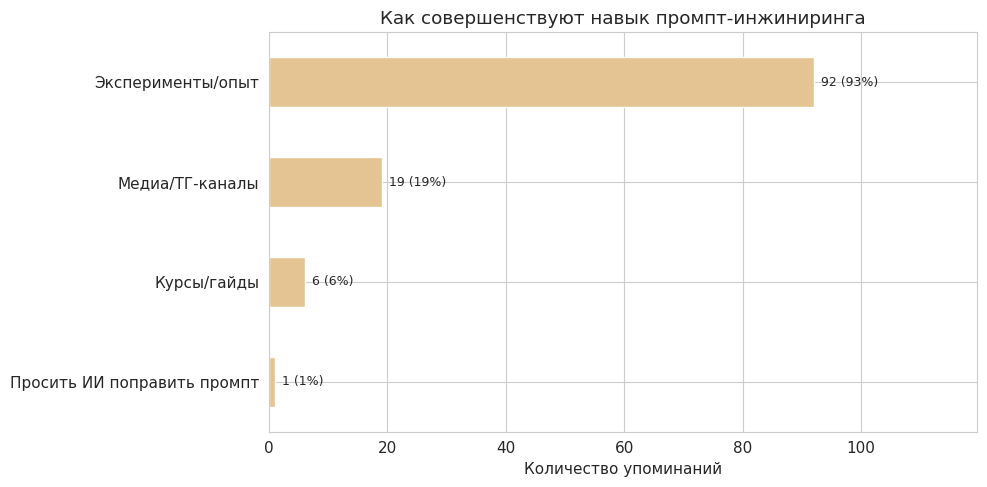

In [17]:
skill_items = []
skill_role_rows = []
for _, row in df.iterrows():
    val = row[cols['prompt_skills']]
    if pd.isna(val):
        continue
    seen = set()
    text = str(val)
    if 'Не совершенствую' in text:
        s = 'Не совершенствую'
        if s not in seen:
            seen.add(s)
            skill_items.append(s)
            skill_role_rows.append({'skill': s, 'role': row['role']})
    if 'Экспериментирую' in text:
        s = 'Эксперименты/опыт'
        if s not in seen:
            seen.add(s)
            skill_items.append(s)
            skill_role_rows.append({'skill': s, 'role': row['role']})
    if 'Подписан на медиа' in text or 'тг-канал' in text:
        s = 'Медиа/ТГ-каналы'
        if s not in seen:
            seen.add(s)
            skill_items.append(s)
            skill_role_rows.append({'skill': s, 'role': row['role']})
    if 'Воркшопы МД' in text:
        s = 'Воркшопы МД'
        if s not in seen:
            seen.add(s)
            skill_items.append(s)
            skill_role_rows.append({'skill': s, 'role': row['role']})
    if 'целенаправленно' in text or 'курсы' in text.lower() or 'гайды' in text.lower():
        s = 'Курсы/гайды'
        if s not in seen:
            seen.add(s)
            skill_items.append(s)
            skill_role_rows.append({'skill': s, 'role': row['role']})
    if 'клод поправить промпт' in text.lower() or 'просить ии' in text.lower():
        s = 'Просить ИИ поправить промпт'
        if s not in seen:
            seen.add(s)
            skill_items.append(s)
            skill_role_rows.append({'skill': s, 'role': row['role']})

skill_counts = pd.Series(Counter(skill_items)).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 5))
skill_counts.plot.barh(ax=ax, color=PALETTE[6])
ax.set_title('Как совершенствуют навык промпт-инжиниринга')
ax.set_xlabel('Количество упоминаний')
add_pct_labels(ax, total=len(df), horizontal=True)
ax.set_xlim(0, skill_counts.max() * 1.3)
plt.tight_layout()
plt.show()

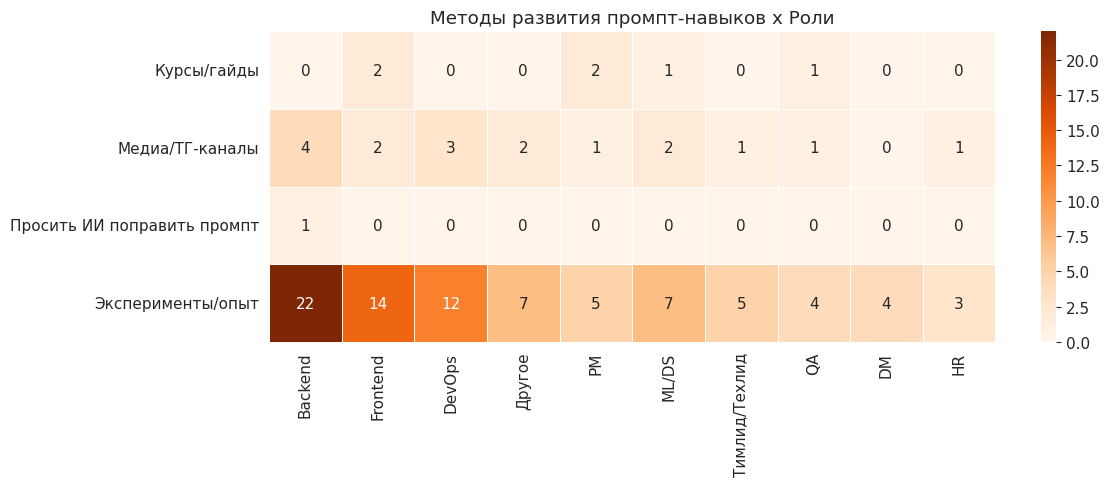

In [18]:
skill_role_df = pd.DataFrame(skill_role_rows)
skill_role_ct = pd.crosstab(skill_role_df['skill'], skill_role_df['role'])
skill_role_ct = skill_role_ct[[r for r in top_roles if r in skill_role_ct.columns]]

fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(skill_role_ct, annot=True, fmt='d', cmap='Oranges', ax=ax, linewidths=0.5)
ax.set_title('Методы развития промпт-навыков x Роли')
ax.set_ylabel('')
ax.set_xlabel('')
plt.tight_layout()
plt.show()

## 10. Что изменилось «до» и «после» использования ИИ

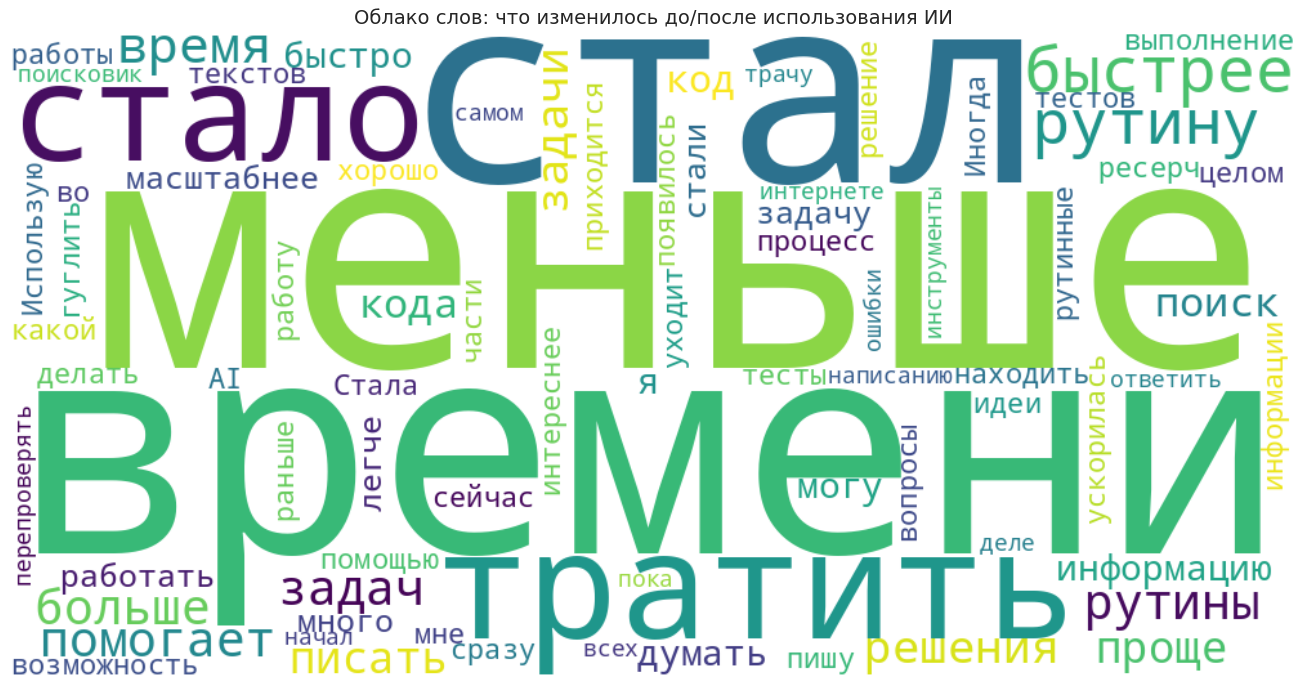

Ответов: 97

Примеры ответов:
  1. стал меньше времени тратить на ресерч
  2. Использую как отличный поисковик
  3. Затрудняюсь ответить, начал этим заниматься не так давно
  4. Меньше трачу времени на рутинные задачи по написанию кода
  5. сейчас мне абсолютно пофиг на чем писать код. Питон, го, C++ или TypeScript. Сейчас я пишу и разбираюсь в коде с помощью AI и мне это по-душе. 
  6. стал немного меньше времени тратить на поиск в интернете
  7. тексты стали интереснее, переводы корректнее
  8. На самом деле мне ИИ помогает избавится от рутины, но все также необходимо перепроверять за ним.
  9. Основное преимущество - сильная экономия времени во всех аспектах. AI инструменты упрощают генерацию конфигов, сокращают ошибки и позволяют быстро нах
  10. По времени разработки пока то же самое, сильно сократилось время на рисерч, процесс работы стал разнообразнее/интереснее, также ИИ подкидывает новые в


In [19]:
before_after = df[cols['before_after']].dropna().astype(str)
before_after = before_after[~before_after.str.strip().isin(['-', 'нет', 'Нет', '', '-\n'])]
ba_text = ' '.join(before_after.values)

if len(ba_text.strip()) > 20:
    wc = WordCloud(width=1000, height=500, background_color='white',
                   stopwords=STOP_WORDS_RU, max_words=80, collocations=False).generate(ba_text)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title('Облако слов: что изменилось до/после использования ИИ', fontsize=14)
    plt.tight_layout()
    plt.show()

print(f'Ответов: {len(before_after)}')
print('\nПримеры ответов:')
for i, t in enumerate(before_after.head(10).values, 1):
    print(f'  {i}. {t[:150]}')

## 11. Потенциал ИИ (перспектива 2 года)

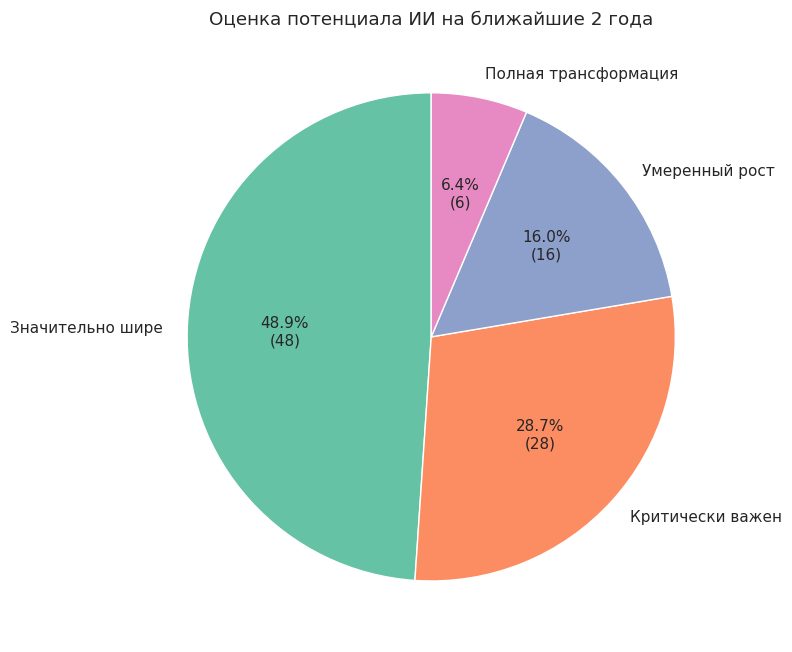

In [20]:
potential = df[cols['ai_potential']].value_counts()
short_potential = {
    'ИИ станет использоваться значительно шире и чаще': 'Значительно шире',
    'ИИ станет критически важен': 'Критически важен',
    'Полная трансформация профессии': 'Полная трансформация',
    'Умеренный рост применения': 'Умеренный рост',
}

fig, ax = plt.subplots(figsize=(8, 8))
labels = [short_potential.get(v, v) for v in potential.index]
ax.pie(
    potential.values, labels=labels,
    autopct=lambda p: f'{p:.1f}%\n({int(round(p*len(df)/100))})',
    startangle=90, colors=PALETTE[:len(potential)],
    textprops={'fontsize': 11}
)
ax.set_title('Оценка потенциала ИИ на ближайшие 2 года')
plt.tight_layout()
plt.show()

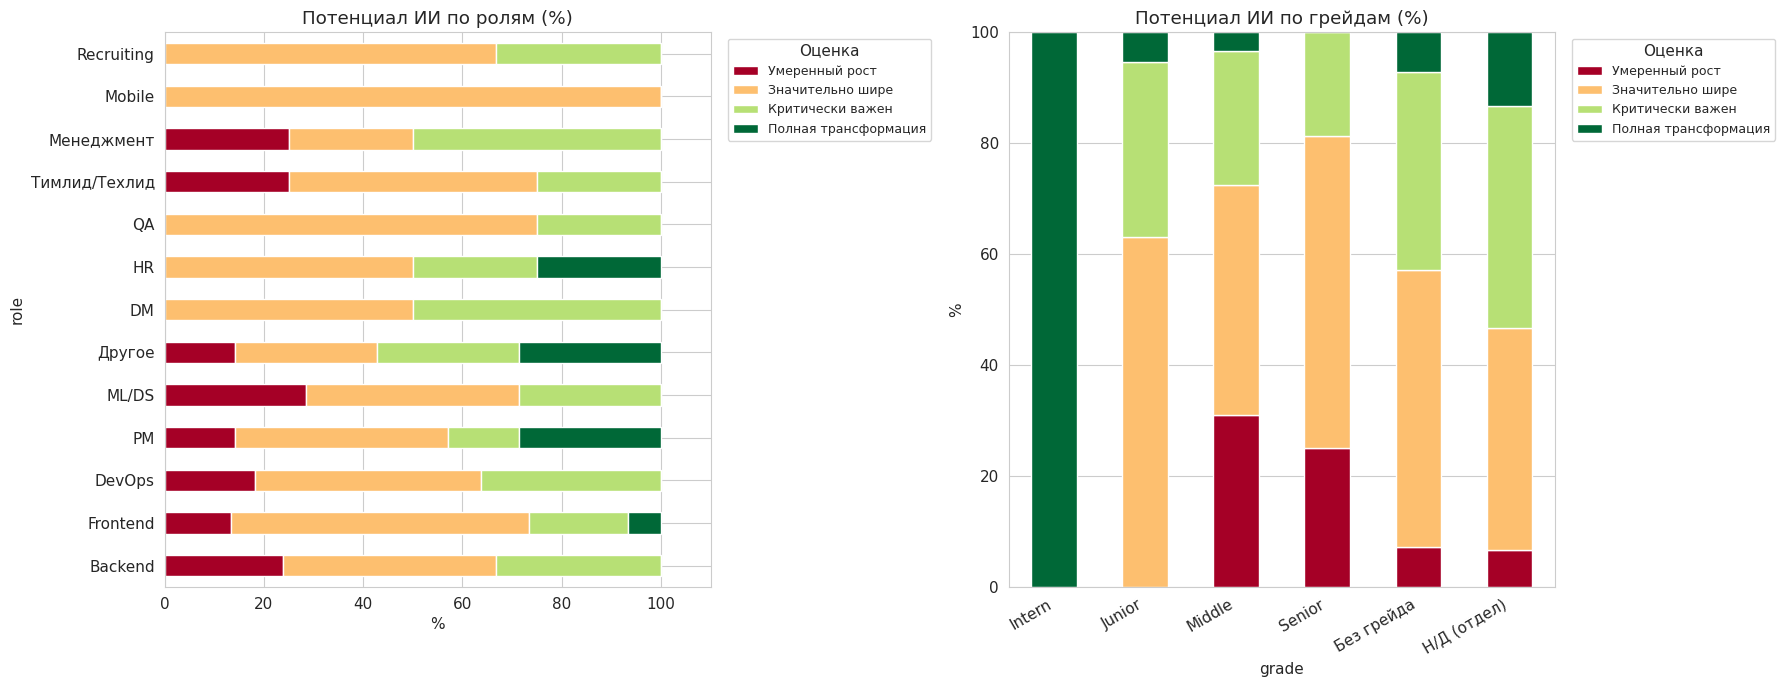

In [21]:
df['potential_short'] = df[cols['ai_potential']].map(short_potential).fillna(df[cols['ai_potential']])
POTENTIAL_ORDER = ['Умеренный рост', 'Значительно шире', 'Критически важен', 'Полная трансформация']

pot_role = pd.crosstab(df['role'], df['potential_short'])
pot_role = pot_role.reindex(columns=[p for p in POTENTIAL_ORDER if p in pot_role.columns])
pot_role = pot_role.loc[pot_role.sum(axis=1).sort_values(ascending=False).index]
pot_role_pct = pot_role.div(pot_role.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

pot_role_pct.plot.barh(stacked=True, ax=axes[0], colormap='RdYlGn')
axes[0].set_title('Потенциал ИИ по ролям (%)')
axes[0].set_xlabel('%')
axes[0].legend(title='Оценка', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
axes[0].set_xlim(0, 110)

pot_grade = pd.crosstab(df['grade'], df['potential_short'])
pot_grade = pot_grade.reindex(index=[g for g in GRADE_ORDER_SHORT if g in pot_grade.index])
pot_grade = pot_grade.reindex(columns=[p for p in POTENTIAL_ORDER if p in pot_grade.columns])
pot_grade_pct = pot_grade.div(pot_grade.sum(axis=1), axis=0) * 100

pot_grade_pct.plot.bar(stacked=True, ax=axes[1], colormap='RdYlGn')
axes[1].set_title('Потенциал ИИ по грейдам (%)')
axes[1].set_ylabel('%')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30, ha='right')
axes[1].legend(title='Оценка', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

## 12. Как компания может помочь

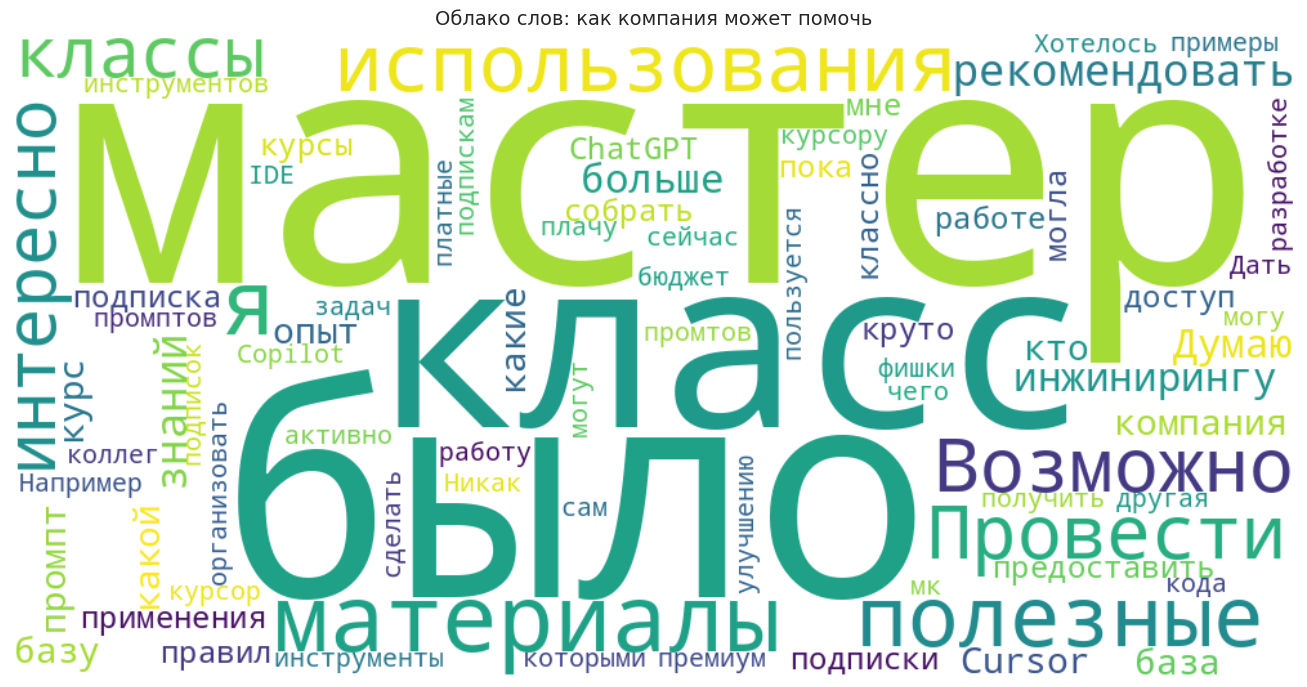

Ответов: 69

Примеры ответов:
  1. предоставить платную версию
  2. Провести мастер класс. Что-то типа "ИИ для самых маленьких и тупых"
  3. Да, инструкция "Как начать" или какая то другая вводная дока очень бы помогла, ну и конечно можете оплатить подписку
  4. показать кто как пользуется инструментами. 
  5. собрать курс какой-то было бы круто
  6. Было бы интересно перенять опыт у тех, кто более активно использует ИИ в работе. Например, с интеграцией в IDE. На данный момент я преуспел только в и
  7. Давайте создадим топик в чате в телеге, где будем делиться кейсами использования
  8. Я бы хотел чтобы компания проработала методологию оценки эффективности использования ИИ. То есть, нас просят активно использовать ИИ предполагая что н
  9. Предоставлять платные решения, от ИИ инструментов на корпоративной основе.
  10. Было бы классно выделять бюджет на платные подписки. Я сейчас плачу за ТГ премиум, так как оформление постов и количество текста, который я могу публи


In [22]:
company_help = df[cols['company_help']].dropna().astype(str)
company_help = company_help[~company_help.str.strip().isin(['-', 'нет', 'Нет', '', '-\n', 'Не знаю'])]
ch_text = ' '.join(company_help.values)

if len(ch_text.strip()) > 20:
    wc = WordCloud(width=1000, height=500, background_color='white',
                   stopwords=STOP_WORDS_RU, max_words=80, collocations=False).generate(ch_text)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title('Облако слов: как компания может помочь', fontsize=14)
    plt.tight_layout()
    plt.show()

print(f'Ответов: {len(company_help)}')
print('\nПримеры ответов:')
for i, t in enumerate(company_help.head(10).values, 1):
    print(f'  {i}. {str(t)[:150]}')

## 13. Ключевые выводы и рекомендации

In [23]:
total = len(df)
daily_plus = len(df[df['freq'].isin(['Каждый день', 'В IDE/workflow', 'Параллельный режим'])])
daily_pct = daily_plus / total * 100
never = len(df[df['freq'] == 'Никогда'])

prompts_23 = len(df[df['prompts_short'] == '2-3 промпта'])
prompts_23_pct = prompts_23 / total * 100

top_tool = tool_counts.idxmax() if len(tool_counts) > 0 else 'N/A'
top_tool_count = tool_counts.max() if len(tool_counts) > 0 else 0

critical_transform = len(df[df['potential_short'].isin(['Критически важен', 'Полная трансформация'])])
critical_pct = critical_transform / total * 100

from IPython.display import Markdown, display

summary = f"""### Основные показатели

| Метрика | Значение |
|---|---|
| Всего респондентов | **{total}** |
| Используют ИИ ежедневно+ | **{daily_plus}** ({daily_pct:.0f}%) |
| Не используют ИИ | **{never}** |
| Требуется 2-3 промпта | **{prompts_23}** ({prompts_23_pct:.0f}%) |
| Самый популярный инструмент | **{top_tool}** ({top_tool_count} упоминаний) |
| Считают ИИ критически важным / трансформирующим | **{critical_transform}** ({critical_pct:.0f}%) |

---

### Ключевые выводы

1. **Широкое проникновение**: {daily_pct:.0f}% используют ИИ ежедневно или чаще. Только {never} человек не используют ИИ вообще.

2. **Промпт-зрелость на среднем уровне**: {prompts_23_pct:.0f}% нуждаются в 2-3 промптах — большинству требуются уточнения.

3. **{top_tool} — лидер**: доминирует среди используемых инструментов ({top_tool_count} упоминаний из {total}).

4. **Основные задачи**: генерация идей, написание текста/документации, поиск информации — лидируют по упоминаниям.

5. **Главная польза**: ускорение работы и снижение рутины — наиболее ценимые аспекты.

6. **Осторожность**: частые упоминания галлюцинаций, необходимости проверки кода, рисков для джуниоров.

7. **Оптимистичный прогноз**: {critical_pct:.0f}% считают, что ИИ станет критически важным или трансформирует профессию.

---

### Рекомендации

1. **Оплата подписок** — самый частый запрос в "как компания может помочь" (Cursor, ChatGPT Plus).
2. **Мастер-классы и воркшопы** — многие просят обучение, особенно формат "ИИ для начинающих".
3. **Обмен опытом** — парные сессии, демо использования ИИ коллегами.
4. **Внимание к рискам** — внедрить обязательный code review для AI-сгенерированного кода.
5. **Стандартизация инструментов** — определить рекомендуемый стек ИИ-инструментов для компании.
"""

display(Markdown(summary))

### Основные показатели

| Метрика | Значение |
|---|---|
| Всего респондентов | **99** |
| Используют ИИ ежедневно+ | **72** (73%) |
| Не используют ИИ | **1** |
| Требуется 2-3 промпта | **58** (59%) |
| Самый популярный инструмент | **ChatGPT** (53 упоминаний) |
| Считают ИИ критически важным / трансформирующим | **33** (33%) |

---

### Ключевые выводы

1. **Широкое проникновение**: 73% используют ИИ ежедневно или чаще. Только 1 человек не используют ИИ вообще.

2. **Промпт-зрелость на среднем уровне**: 59% нуждаются в 2-3 промптах — большинству требуются уточнения.

3. **ChatGPT — лидер**: доминирует среди используемых инструментов (53 упоминаний из 99).

4. **Основные задачи**: генерация идей, написание текста/документации, поиск информации — лидируют по упоминаниям.

5. **Главная польза**: ускорение работы и снижение рутины — наиболее ценимые аспекты.

6. **Осторожность**: частые упоминания галлюцинаций, необходимости проверки кода, рисков для джуниоров.

7. **Оптимистичный прогноз**: 33% считают, что ИИ станет критически важным или трансформирует профессию.

---

### Рекомендации

1. **Оплата подписок** — самый частый запрос в "как компания может помочь" (Cursor, ChatGPT Plus).
2. **Мастер-классы и воркшопы** — многие просят обучение, особенно формат "ИИ для начинающих".
3. **Обмен опытом** — парные сессии, демо использования ИИ коллегами.
4. **Внимание к рискам** — внедрить обязательный code review для AI-сгенерированного кода.
5. **Стандартизация инструментов** — определить рекомендуемый стек ИИ-инструментов для компании.
